# 1. Importing the libraries 

**pgmpy** being the heart of the modeling basis.

In [2]:
import os
from itertools import combinations, product

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

warnings.simplefilter(action='ignore', category=UserWarning)
from PyImpetus import PPIMBC

import matplotlib.pyplot as plt
import networkx as nx

import numpy as np

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import XMLBIFWriter

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

# 2. Description of the dataset

The original dataset was retrieved from Kaggle named **Cleveland Clinic Heart Disease Dataset** for Predicting Coronary Heart Disease by Non-Invasive Means.

The dataset contains the following attributes:

1. Age: age of the patient [years]

2. Sex: sex of the patient

   - M: Male(1)
   
   - F: Female(0)

4. ChestPainType: chest pain type

   - TA: Typical Angina(0)
   
    - ATA: Atypical Angina(1)
   
    - NAP: Non-Anginal Pain(2)
   
    - ASY: Asymptomatic(3)

5. RestingBP: resting blood pressure [mm Hg]

6. Cholesterol: serum cholesterol [mm/dl]

7. FastingBS: fasting blood sugar

    - 1: if FastingBS > 120 mg/dl
   
    - 0: otherwise

9. RestingECG: resting electrocardiogram results

    - Normal: Normal(0)
   
    - ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)(1)
   
    - LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria(2)

11. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

12. ExerciseAngina: exercise-induced angina

    - Y: Yes(0)
    
    - N: No(1)

14. Oldpeak: oldpeak = ST_Depression [Numeric value measured in depression]

15. ST_Slope: the slope of the peak exercise ST segment

    - Up: upsloping
    
    - Flat: flat
    
    - Down: downsloping

17. HeartDisease: target variable

    - 1: heart disease
    
    - 0: Normal

# 3. Discretization

Firstly, each of the continuous variables are discretized using the cut function of pandas library.

The discretization is performed in such a way to be as close as possible to the standard medical guidelines; 
for example, the RestingBP (indicating the resting blood pressure) is discretized in 3 categories: 90-120, 120-140 and 140+ according to the following intervals: 
[90,120], 
[120,140], 
[140,+∞].

The same procedure is done for the other continuous variables such as Cholesterol and Oldpeak.

We have also dropped some rows where the Cholesterol or the RestingBP are equal to 0, because we considered them nan values.

In [5]:
def clean_data(data: pd.DataFrame):
    
    data = data[~(data['Cholesterol'] == 0) & ~(data['RestingBP'] == 0)]
    
    # Create new columns directly in the original DataFrame
    data["Age"] = pd.cut(x=data["Age"], bins=[20, 40, 50, 60, 70, np.Inf], labels=[
        "20-40", "40-50", "50-60", "60-70", "70+"])
    
    data["RestingBP"] = pd.cut(x=data["RestingBP"], bins=[90, 120, 140, np.Inf], labels=[
        "90-120", "120-140", "140+"])
    
    data["Cholesterol"] = pd.cut(x=data["Cholesterol"], bins=[
        -np.Inf, 200, 240, np.Inf], labels=["<=200", "200-240", "240+"])
    
    data["MaxHR"] = pd.qcut(x=data["MaxHR"], q=4, labels=[
        "low", "medium", "high", "very-high"])  # binning using quartiles
    
    data["Oldpeak"] = pd.cut(x=data["Oldpeak"], bins=[-np.Inf, 0.5, 1, 2, np.Inf], labels=[
        "<=0.5", "0.5-1", "1-2", "2+"])
    
    data['FastingBS'] = data['FastingBS'].map({0: 'N', 1: 'Y'})
    data['Sex'] = data['Sex'].map({0: 'F', 1: 'M'})
    data['ChestPainType'] = data['ChestPainType'].map({0: 'TA', 1: 'ATA', 2: 'NAP', 3: 'ASY'})
    data['RestingECG'] = data['RestingECG'].map({0: 'Normal', 1: 'ST', 2: 'LVH'})
    data['ExerciseAngina'] = data['ExerciseAngina'].map({0: 'N', 1: 'Y'})
    data['ST_Slope'] = data['ST_Slope'].map({0: 'Up', 1: 'Flat', 2: 'Down'})
    
    return data

In [6]:
data = pd.read_csv('heart.csv')

data.rename(columns={
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPainType',
    'chol': 'Cholesterol',
    'trestbps': 'RestingBP',
    'restecg': 'RestingECG',
    'thalach': 'MaxHR',
    'exang': 'ExerciseAngina',
    'oldpeak': 'Oldpeak',
    'slope': 'ST_Slope',
    'fbs': 'FastingBS',
    'target': 'HeartDisease'
}, inplace=True)

data.drop(['ca', 'thal'], axis=1, inplace=True)

df = clean_data(data)
df.to_csv('heart_cleaned.csv')

print("The dataset contains %s observations and %s attributes" % df.shape)

df.head()

The dataset contains 303 observations and 12 attributes


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,60-70,M,TA,140+,200-240,Y,LVH,medium,N,2+,Down,0
1,60-70,M,ASY,140+,240+,N,LVH,low,Y,1-2,Flat,1
2,60-70,M,ASY,90-120,200-240,N,LVH,low,Y,2+,Flat,1
3,20-40,M,NAP,120-140,240+,N,Normal,very-high,N,2+,Down,0
4,40-50,F,ATA,120-140,200-240,N,LVH,very-high,N,1-2,Up,0


# 4. Data exploration

Back to top
Heart Disease Distribution in the Dataset
The dataset, after the preprocessing, contains 746 samples and 11 features plus the target variable.

The distribution of the target variable HeartDisease is shown in the following plot.

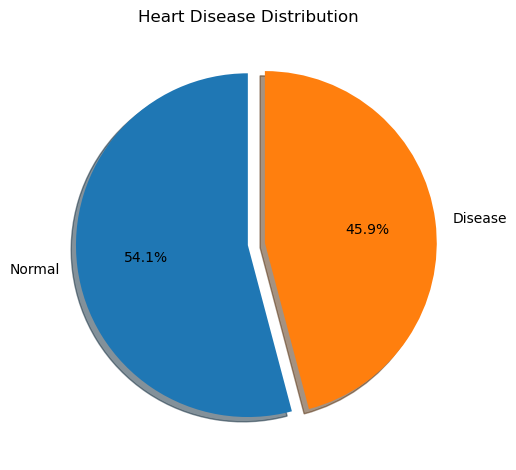

In [8]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[
    0, 0.1], shadow=True, labels=['Normal', 'Disease'], label='', title="Heart Disease Distribution")
plt.tight_layout()
plt.show()

# 5. Train-Test Split

We have split the dataset into `train` and `test` for the sake of evaluating our classificator.

The training set contains 85% of the samples, while the test set contains 15% of the samples and the split is performed using the `train_test_split` function of the `sklearn library`. Thanks to the `stratify` parameter of the procedure, we have mantained the same distribution of the target variable `(Heart disease)` in both the train and test set.

The training set will be used to learn the parameters of the Bayesian Network, while the test set will be used to evaluate the performance of the model in terms of accuracy and other metrics.

In [10]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# 6. Naïve Bayes Network

A Naïve Bayes classifier is a specific type of **classifier** based on a Naïve Bayes network. It is characterized by its semplicity, and it is built upond a **simple assumption**: all the features are conditional independent if the target feature is given.

They are widely used in Machine Learning thanks to their **computational efficiency** and their **ease of implementation**. They can also be expanded with other connections, and we will see that using an **Hill Climbing algorithm** in the next chapter.

Creating a Naïve Bayes network in `pgmpy` ipgmpy is quite simple: once it is clear which are the features and which is the target variable, a simple list comprehension can build the network structure

In [12]:
network = [(target_variable, x) for x in df.columns[:-1]]
naive_bayes = BayesianNetwork(network)

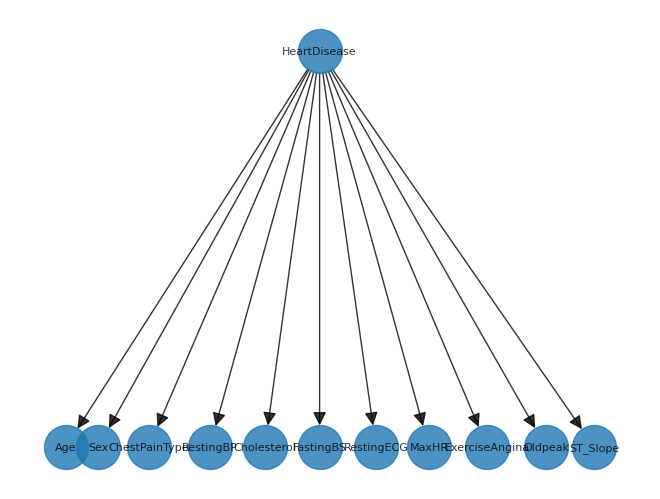

In [13]:
pos = nx.nx_agraph.graphviz_layout(naive_bayes, prog="dot")
nx.draw(naive_bayes, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

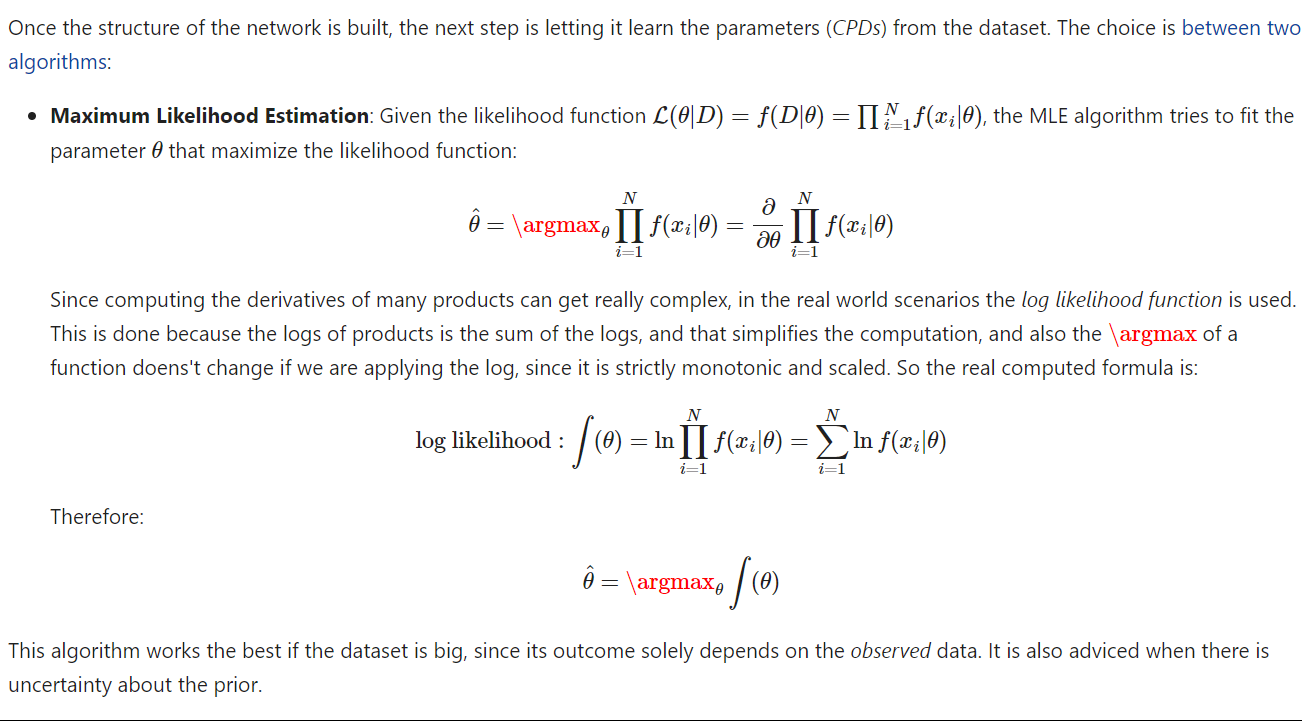
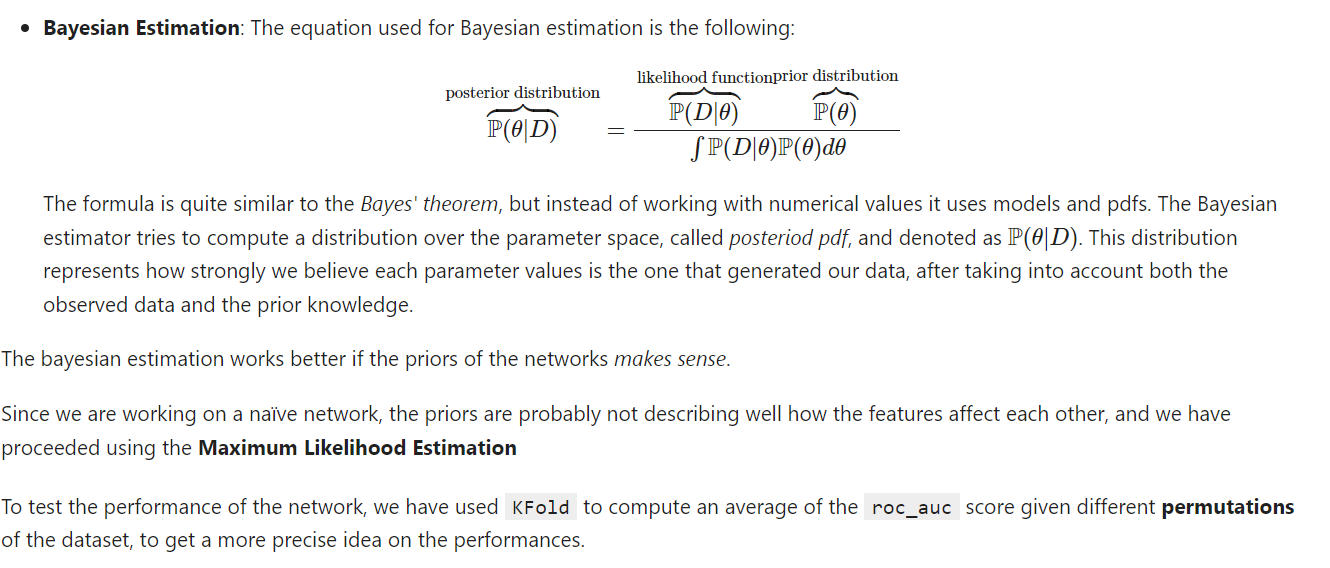

In [15]:
kfold = KFold(5, shuffle=True, random_state=42)

def bayesian_kfold(df, model, metric):
    score = []
    predictions = []
    for train, test in kfold.split(df):
        model.cpds = []
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.drop(columns=target_variable, axis=1).iloc[test, :])
        score.append(
            metric(df[target_variable].iloc[test], y_pred[target_variable]))
        predictions.append(y_pred)
    return sum(score) / len(score), predictions[0]

In [16]:
%%capture
roc_auc_value, _ = bayesian_kfold(df, naive_bayes, roc_auc_score)

In [17]:
print(f"The roc_auc score for the naive bayesian network is {roc_auc_value:.2f}")

The roc_auc score for the naive bayesian network is 0.79


# 7. Improving the Naïve Bayes network with Hill Climbing

The first approach we use to learn the structure of the Bayesian Network is the **Hill Climbing algorithm**.

The Hill Climbing algorithm is a greedy search algorithm which starts from an empty network (or an already built one) and adds or removes edges to maximize a score. The score is usually the **Bayesian Information Criterion (BIC)**, which is a trade-off between the likelihood of the data and the complexity of the model. Since it is a local search algorithm, it strongly depends on the starting network, and there is a very high risk of being stuck on a local Maximum. To avoid this, the algorithm is usually run multiple times with different initializations and the best network is selected.

The Hill Climbing algorithm is implemented in the `pgmpy` library. We have compared different scoring method to see which one works the best with our dataset.

In [19]:
%%capture

scores = {} # Dictionary to store the roc_auc_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network    
    model = BayesianNetwork(network)
    scores[scoring], _ = bayesian_kfold(df, model, roc_auc_score)

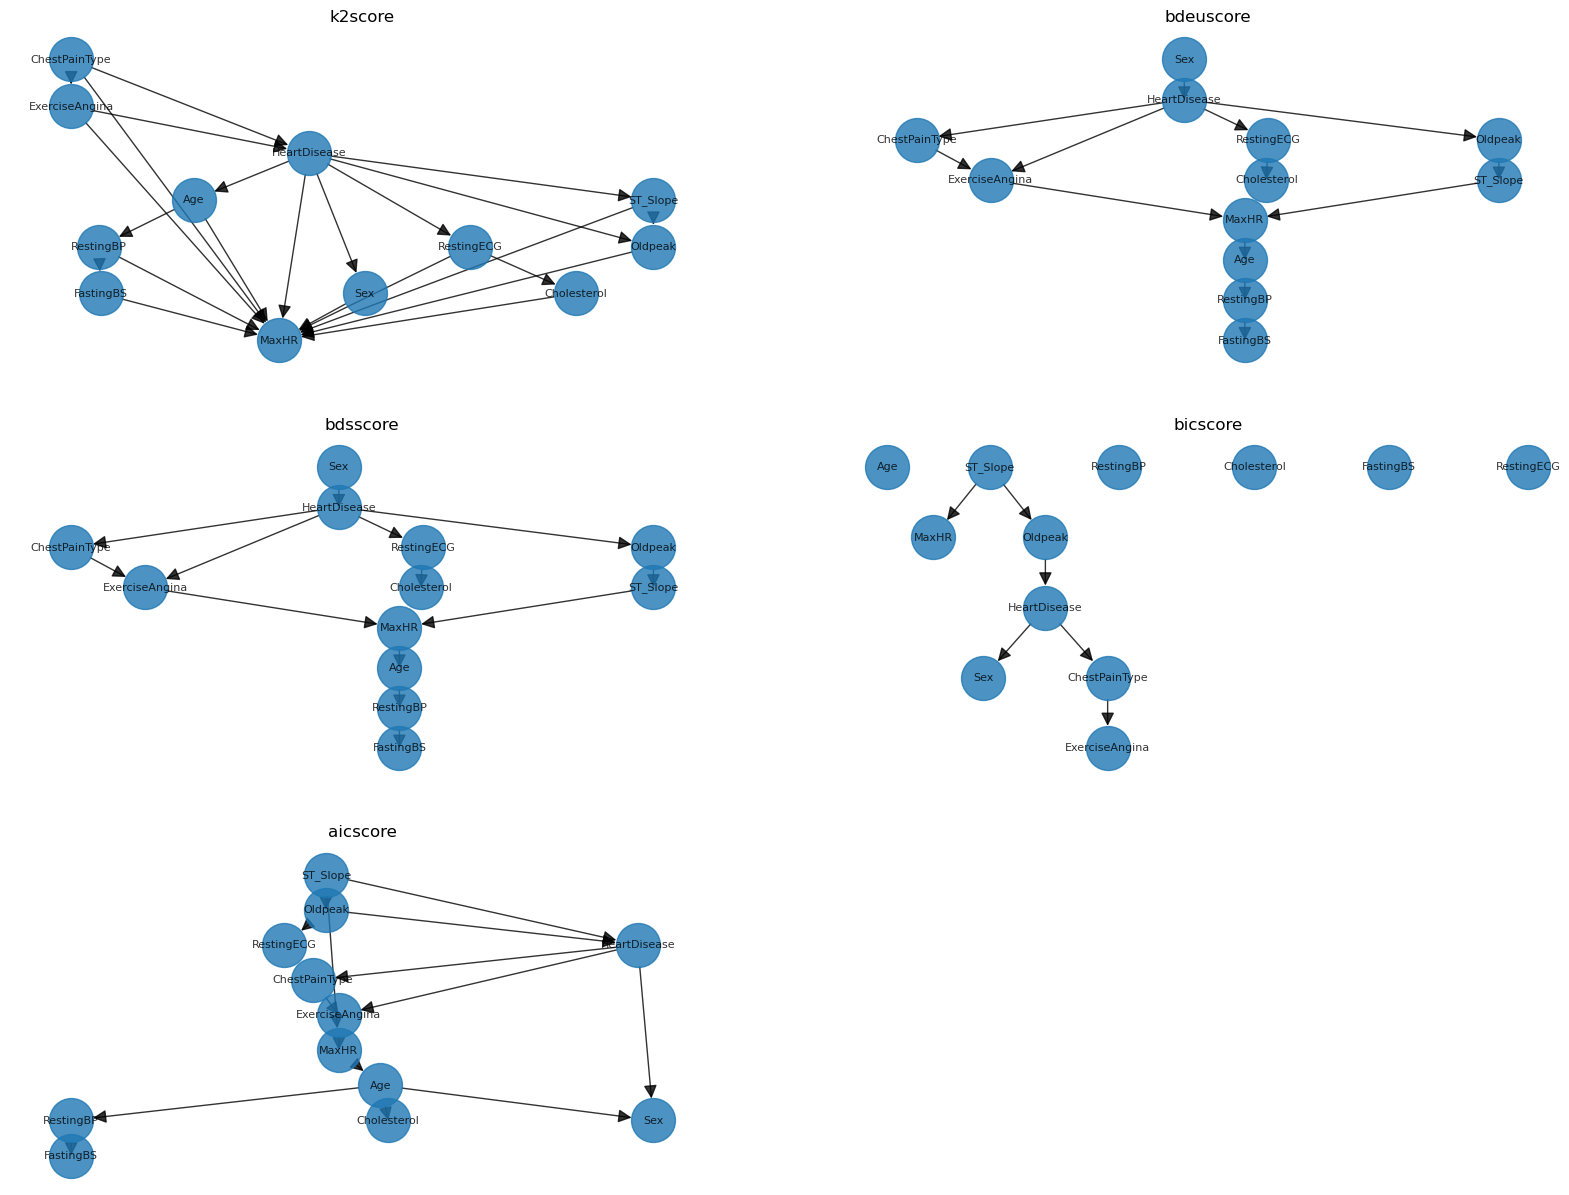

In [20]:
fig = plt.figure(figsize=(20,15))
i = 1
for scoring in networks:
    plt.subplot(3,2,i)
    pos = nx.nx_agraph.graphviz_layout(networks[scoring], prog="dot")
    nx.draw(networks[scoring], pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8) 
    plt.title(scoring) 
    i += 1
plt.show()

In [21]:
pd.DataFrame(scores, index = ['ROC AUC'])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
ROC AUC,0.730404,0.77351,0.77351,0.775169,0.7588


The performances are slighly higher w.r.t the Naïve Bayesian Classifier, but the network doesn't have any clear semantic. For example, the nodes `Age` and `Sex` should not have parent nodes, because they are not influenced by any other feature (but it makes sense that they influence other features). This means that Hill Climbing learns a structure that may even have good performance, but it does not have (in most cases) semantical correctness.

From the comparison of the scoring parameters of the Hill Climbing above we can notice that they have an overall similar `ROC AUC`. However, the networks are different from each other and each network is not fully explainable. This means that:

- the choice of the scoring method does not influence so much the performance, even if the structures of the networks are different
- since the semantic is problematic, we need to add some constraint through blacklisting/whitelisting. This means that the Hill Climbing will not explore the connections written in the blacklist while they will use the connections reported in the whitelist.

Given these consideration we can choose as the scoring method for the Hill Climbing the `bdeuscore`, since it has good performance it is more general w.r.t `bicscore`.

# 8. How Bayesian Networks are represented?
The libraries used in this notebook represent the bayesian network as a **Directed Acyclic Graph (DAG)**.

A DAG is a graph that has a **topological ordering**, which means that the edges are oriented: they have a starting node and a destination node. This is important because the edges in the Bayesian Network represent the causal relation between the variables: the edge goes from the cause to the effect.

In [24]:
%%capture

hc_unconst = HillClimbSearch(df, use_cache=False).estimate(scoring_method='bdeuscore')

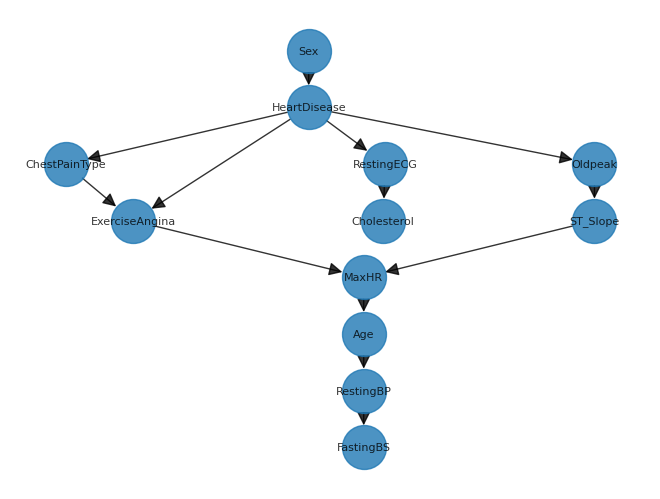

In [25]:
pos = nx.nx_agraph.graphviz_layout(hc_unconst, prog="dot")
nx.draw(hc_unconst, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

From the above graph, we can see that the structure of the Bayesian Network learnt from the data has some edges that are meaningless.

For example, the edges that points to `Age` and `Sex` does not make sense, because those features are not a consequence of other features, but it is valid the vice versa.

This is because the Hill Climbing algorithm is not aware of the domain knowledge and it tries to maximize the score by adding or removing edges. In the next section, we will use the domain knowledge to remove the edges that are not meaningful and to add the edges that are meaningful.

# 9. Adding a blacklist

In this section we will add a blacklist to the Hill Climbing algorithm that will limit the creation of unexplainable networks. The blacklist is passed as a parameter to the Hill Climbing algorithm.

In [28]:
black_list = [('HeartDisease', 'Cholesterol'), 
              ('Oldpeak', 'HeartDisease'),
              ('ST_Slope', 'HeartDisease'),
              ('ST_Slope', 'MaxHR'),
              ('ExerciseAngina', 'Cholesterol'),
              ('ST_Slope', 'Oldpeak'),
              ('ExerciseAngina', 'RestingECG'),
              ('ExerciseAngina', 'ChestPainType')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [29]:
%%capture
hc_const = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

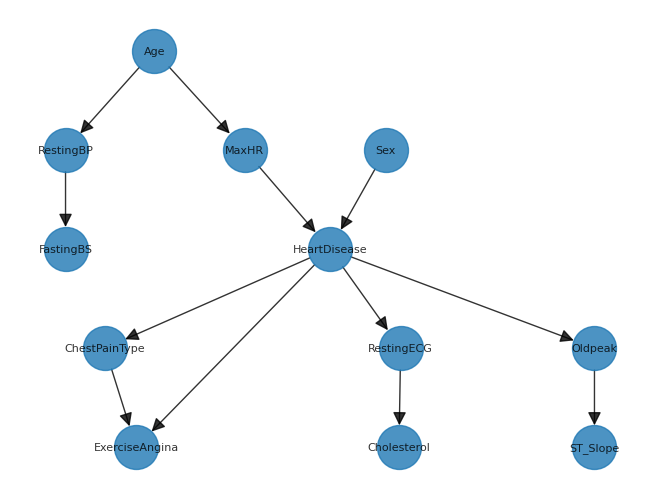

In [30]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

# 10. Manually adding edges to the network

We are going to add some edges that make sense by referring medical documentation. The list is the following:
- Age → Cholesterol
- Age → MaxHR
- Age → RestingBP
- Age → FastingBS
- Sex → Cholesterol
- Sex → ExerciseAngina
- Sex → HeartDisease
- Cholesterol → RestingBP
- Cholesterol → HeartDisease
- RestingBP → HeartDisease
- FastingBS → RestingECG
- RestingECG → HeartDisease
- MaxHR → ExerciseAngina
- ExerciseAngina → Oldpeak
- ExerciseAngina → HeartDisease
- Oldpeak → ST_Slope
- HeartDisease → Oldpeak
- HeartDisease → ST_Slope
- HeartDisease → ChestPainType

In [32]:
hc_const = nx.DiGraph()

# Add edges to the graph
edges = [
    ('Age', 'Cholesterol'),
    ('Age', 'MaxHR'),
    ('Age', 'FastingBS'),
    ('Age', 'RestingBP'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', 'Cholesterol'),
    ('Sex', 'HeartDisease'),
    ('Cholesterol', 'RestingBP'),
    ('Cholesterol', 'HeartDisease'),
    ('RestingBP', 'HeartDisease'),
    ('FastingBS', 'RestingECG'),
    ('RestingECG', 'HeartDisease'),
    ('MaxHR', 'ExerciseAngina'),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'HeartDisease'),
    ('Oldpeak', 'ST_Slope'),
    ('HeartDisease', 'Oldpeak'),
    ('HeartDisease', 'ST_Slope'),
    ('HeartDisease', 'ChestPainType'),
]

hc_const.add_edges_from(edges)

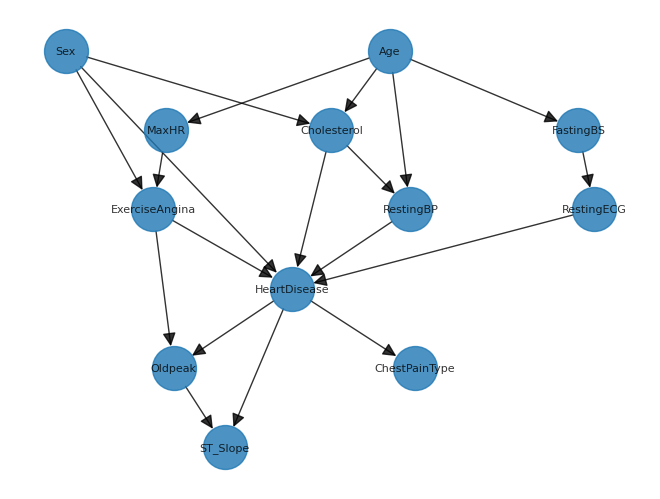

In [33]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

The structure now starts to have a more realistic semantic meaning but it is still not explainable due to the presence of some edges that are not meaningful. For example, the edge between FatingBS and RestingECG is meaningless because the two variables are not related to each other.

Inferring the structure of the network from the data is not enough to obtain a meaningful one, we need to use domain knowledge to build a network that is semantically correct from scratch. In the next section we will do that.

>Just for comparison, here are the performance of this constrained network compared to the results. Firstly we need to convert the estimated DAG to a Bayesian Network and then we will learn the parameters of the network from the data using the fit method of the BayesianNetwork class using the MaximumLikelihoodEstimator as the estimator.

In [35]:
hc_const_model = BayesianNetwork(hc_const.edges())

In [36]:
%%capture
hc_const_model.cpds = [] # Clear the cpds
hc_const_model.fit(train, estimator=MaximumLikelihoodEstimator)
hc_const_model.get_cpds()
assert hc_const_model.check_model()

In [37]:
%%capture
accuracy, _ = bayesian_kfold(df, hc_const_model, accuracy_score)
roc_auc, _ = bayesian_kfold(df, hc_const_model, roc_auc_score)

In [38]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.769
ROC AUC: 0.766


# 11. Construction of the network

The references for the Bayesian Network with Domain Knowledge are the following:

- Age → Cholesterol
- Age → RestingECG
- Age → MaxHR
- Age → RestingBP
- Age → FastingBS
- Age → HeartDisease
- Sex → Cholesterol
- Sex → MaxHR
- Sex → ExerciseAngina
- Sex → HeartDisease 
- RestingECG → HeartDisease 
- MaxGR → ExerciseAngina
- Cholesterol → HeartDisease
- Cholesterol → RestingBP
- RestingBP → FastinBS
- FastingBS → HeartDisease
- ExerciseAngina → HeartDisease
- ExerciseAngina → Oldpeak 
- ExerciseAngina → ST_Slope 
- HeartDisease → Oldpeak 
- HeartDisease → ST_Slope
- HeartDisease → ChestPainType
- Oldpeak → ST_Slope


In [40]:
domain_kg_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'RestingECG'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', 'HeartDisease'),
    ('Sex', 'Cholesterol'),
    ('Sex', 'MaxHR'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', 'HeartDisease'),
    ('RestingECG', 'HeartDisease'),
    ('MaxHR', 'ExerciseAngina'),
    ('Cholesterol', 'HeartDisease'),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', 'HeartDisease'),
    ('ExerciseAngina', 'HeartDisease'),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'ST_Slope'),
    ('HeartDisease', 'Oldpeak'),
    ('HeartDisease', 'ST_Slope'),
    ('HeartDisease', 'ChestPainType'),
    ('Oldpeak', 'ST_Slope'),
]
)

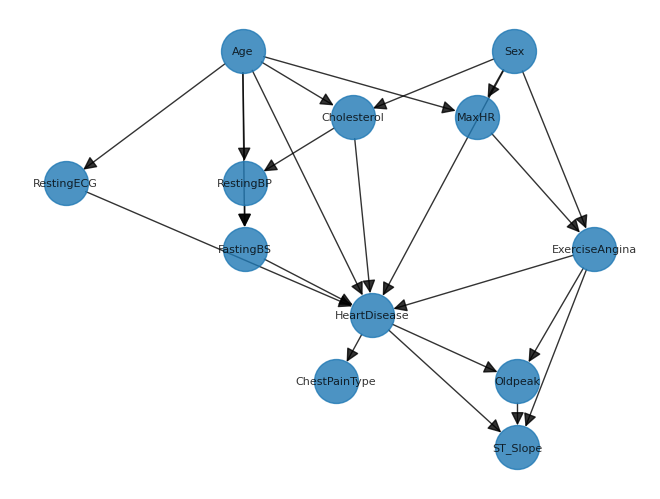

In [41]:
pos = nx.nx_agraph.graphviz_layout(domain_kg_model, prog="dot")
nx.draw(domain_kg_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

# 12. Changing the estimator

As stated in the paragraph 4, until now we have used the `MaximumLikelihoodEstimator` to estimate the CPDs of our networks since they lack semantic meaningfulness.

Now that we focus on the semantic correctness of the Bayesian Network, `BayesianEstimator` is a better choice, since it's used whene there is prior knowledge of the domain.

In [43]:
%%capture
domain_kg_model.cpds = []
domain_kg_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
domain_kg_model.get_cpds()
assert domain_kg_model.check_model()

In [44]:
%%capture

accuracy, _ = bayesian_kfold(df, domain_kg_model, accuracy_score)
roc_auc, y_pred = bayesian_kfold(df, domain_kg_model, roc_auc_score)

In [46]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.743
ROC AUC: 0.742


In [49]:
if not os.path.isdir('model'):
    os.mkdir('model')
domain_kg_model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(domain_kg_model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

# 13. Markov Blanket feature selection algorithm

In this section we will use a Markov Blanket based feature selection algorithm that selects a subset of features by considering their performance both individually as well as a group. This allows the algorithm to not only select the best set of features, but also select the best set of features that play well with each other. The Markov Blanket of a node is the set of nodes that are conditionally independent of the node given the other nodes in the network. In other words, the Markov Blanket of a node is the set of nodes that are the parents, children, and parents of children of the node. The Markov Blanket of a node is the smallest set of nodes that contains all the information about the node.

`PyImpetus` is a library that implements a Markov Blanket based feature selection algorithm. By first using a classifier to determine the features that are most important, and then using a Markov Blanket based feature selection algorithm to select the best set of features, we can create a network that is semantically correct and has the best performance.

First we need to encode the categorical variables using the `OrdinalEncoder` of the `sklearn` library (since for this task we need numeric values). Then we will use the `PyImpetus` library to select the best set of features. We will use the `SVC` as the classifier to determine the features that are most important. Then we will use the `MarkovBlanket` (MB) class of the `PyImpetus` library to select the best set of features.

In [54]:
encoder = OrdinalEncoder().set_output(transform='pandas')

X_enc, _ = encoder.fit_transform(X), y

In [55]:
model_mb = PPIMBC(model=SVC(random_state=42, class_weight="balanced"), p_val_thresh=0.05, num_simul=100,
               simul_size=0.20, simul_type=1, sig_test_type="non-parametric", cv=5, random_state=42, n_jobs=-1, verbose=0)

In [56]:
%%capture

model_mb.fit_transform(X_enc, y.values)

The most important features are: ['ChestPainType', 'Sex', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'MaxHR', 'Cholesterol']


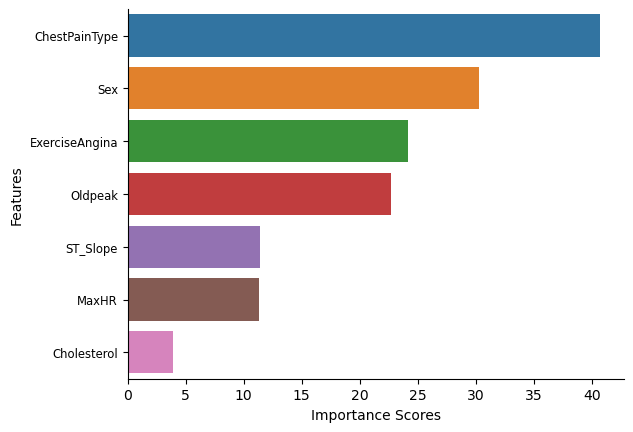

In [57]:
print(f"The most important features are: {model_mb.MB}")

model_mb.feature_importance()

Now we can use the variables selected by the Markov Blanket based feature selection algorithm to build a Bayesian Network that is semantically correct and has the best performance. We will start by taking all the edgs of the Domain Knowledge network and remove the ones that are not selected by the algorithm.

In [59]:
all_nodes = model_mb.MB + [target_variable]
edges = [x for x in list(domain_kg_model.edges()) if x[0] in all_nodes and x[1] in all_nodes]

reduced_network = BayesianNetwork(edges)

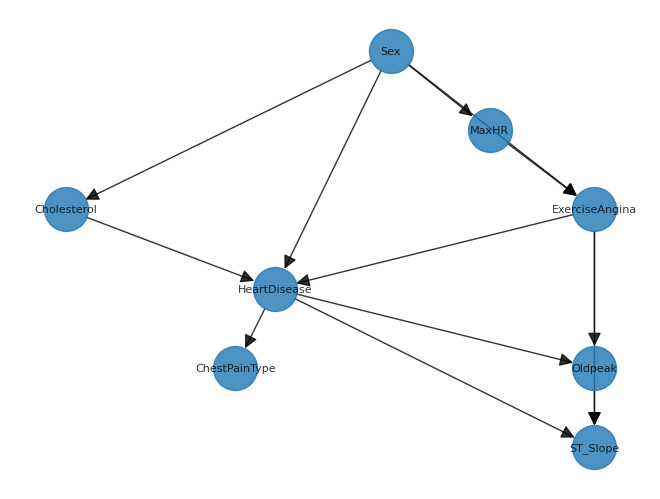

In [60]:
pos = nx.nx_agraph.graphviz_layout(reduced_network, prog="dot")
nx.draw(reduced_network, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [61]:
%%capture
reduced_network.cpds = []
reduced_network.fit(train[list(reduced_network.nodes)], estimator=BayesianEstimator, prior_type="BDeu")
reduced_network.get_cpds()
assert reduced_network.check_model()

In [62]:
removed_vars = list(reduced_network.nodes)
removed_vars.remove(target_variable)

Now we can make predictions about the risk of heart disease in a patient using the network by testing it on the test set with reduced dimensionality.

The network then can be compared in terms of `accuracy` and `ROC AUC` with the previous networks.

In [65]:
%%capture

accuracy, _ = bayesian_kfold(df.loc[:, list(reduced_network.nodes)], reduced_network, accuracy_score)
roc_auc, y_pred = bayesian_kfold(df.loc[:, list(reduced_network.nodes)], reduced_network, roc_auc_score)

In [67]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.785
ROC AUC: 0.783


As a result, the network achieves 0.79 ROC AUC and 0.78 accuracy on the test set. However the network is too simplistic and it does not take into account the majority of the features. The features not included in the network may have complex interactions with the other features and may be important for the prediction of the risk of heart disease in a patient even if they are not selected by the algorithm.

*Thus the further analysis will be performed on the network built using the Domain Knowledge and not on the network built using the Markov Blanket based feature selection algorithm.*

# 14. Network analysis

In particular the interest is to find the **conditional independencies** and **active trails** with respect to some given evidence or to ask for the **Markov Blanket** of a node.

In [70]:
print(f'There can be made {len(domain_kg_model.get_independencies().get_assertions())}',
      'valid independence assertions with respect to the all possible given evidence.')
print('For instance, any node in the network is independent of its non-descendents given its parents:\n',
      f'\n{domain_kg_model.local_independencies(df.columns.tolist())}\n')

print('But we can also find some other independencies in the network given some evidence. For example:\n')

for node in df.columns.tolist():
    for assertion in domain_kg_model.get_independencies(latex=False, include_latents=True).get_assertions():
        if node in assertion.get_assertion()[0] and len(assertion.get_assertion()[2]) < 4 and len(assertion.get_assertion()[1]) < 3 and assertion not in domain_kg_model.local_independencies(df.columns.tolist()).get_assertions():
            print(assertion)
            break

There can be made 9885 valid independence assertions with respect to the all possible given evidence.
For instance, any node in the network is independent of its non-descendents given its parents:
 
(Age ⟂ Sex)
(Sex ⟂ Age, RestingECG)
(ChestPainType ⟂ Age, RestingECG, FastingBS, ExerciseAngina, Oldpeak, Cholesterol, MaxHR, Sex, ST_Slope, RestingBP | HeartDisease)
(RestingBP ⟂ Sex, RestingECG, ExerciseAngina, MaxHR | Cholesterol, Age)
(Cholesterol ⟂ RestingECG, ExerciseAngina, MaxHR | Age, Sex)
(FastingBS ⟂ RestingECG, ExerciseAngina, Cholesterol, MaxHR, Sex | RestingBP, Age)
(RestingECG ⟂ FastingBS, ExerciseAngina, RestingBP, Cholesterol, MaxHR, Sex | Age)
(MaxHR ⟂ RestingBP, Cholesterol, RestingECG, FastingBS | Age, Sex)
(ExerciseAngina ⟂ RestingECG, Age, FastingBS, RestingBP, Cholesterol | MaxHR, Sex)
(Oldpeak ⟂ RestingECG, Age, FastingBS, Cholesterol, MaxHR, Sex, RestingBP, ChestPainType | HeartDisease, ExerciseAngina)
(ST_Slope ⟂ Age, FastingBS, RestingECG, Cholesterol, MaxHR, Sex,

In [71]:
def markov_blanket(model, target_variable):
    return f"Markov blanket of \'{target_variable}\' is {domain_kg_model.get_markov_blanket(target_variable)}"


for column in df.columns:
    print(markov_blanket(domain_kg_model, column))

Markov blanket of 'Age' is ['RestingECG', 'FastingBS', 'HeartDisease', 'ExerciseAngina', 'Cholesterol', 'MaxHR', 'Sex', 'RestingBP']
Markov blanket of 'Sex' is ['Age', 'ExerciseAngina', 'HeartDisease', 'RestingECG', 'FastingBS', 'Cholesterol', 'MaxHR']
Markov blanket of 'ChestPainType' is ['HeartDisease']
Markov blanket of 'RestingBP' is ['Cholesterol', 'Age', 'FastingBS']
Markov blanket of 'Cholesterol' is ['RestingECG', 'Age', 'HeartDisease', 'FastingBS', 'ExerciseAngina', 'Sex', 'RestingBP']
Markov blanket of 'FastingBS' is ['RestingECG', 'Age', 'HeartDisease', 'ExerciseAngina', 'Cholesterol', 'Sex', 'RestingBP']
Markov blanket of 'RestingECG' is ['Age', 'HeartDisease', 'FastingBS', 'ExerciseAngina', 'Cholesterol', 'Sex']
Markov blanket of 'MaxHR' is ['Age', 'ExerciseAngina', 'Sex']
Markov blanket of 'ExerciseAngina' is ['Age', 'HeartDisease', 'Oldpeak', 'RestingECG', 'FastingBS', 'Cholesterol', 'MaxHR', 'Sex', 'ST_Slope']
Markov blanket of 'Oldpeak' is ['ST_Slope', 'HeartDisease', 

# 15. How the combinations of evidences affect the prediction?

In the following chapter we are gonna inference the model in order to understand how the evidence affects the results of the models.

More specifically we are gonna explore how the following combination of evidences affects the prediction of the model:

- `Age` of the patient
- the combinations of `RestingBP` and `FastingBP` of the patient
- the combination of the `Cholesterol` and `Sex` of the patient

In [73]:
target = [target_variable]

def format_string(array):
    string = str(array[0])
    for item in array[1:]: 
        string += f', {item}'
    return string

def exact_inference(model, variables, evidence):
    inference = VariableElimination(model)
    result = inference.query(variables=variables, evidence=evidence)
    return result

def create_dictionary(df, columns):
    dictionary = {}
    for column in columns:
        dictionary[column] = df[column].unique().tolist()
    return dictionary

def get_all_combinations(dictionary):
    if len(dictionary) == 1:
        return [{list(dictionary.keys())[0]: value} for value in dictionary[list(dictionary.keys())[0]]]
    res = []
    for k1, k2 in combinations(dictionary.keys(), 2):
        for v1, v2 in product(dictionary[k1], dictionary[k2]):
            res.append({k1: v1, k2: v2})
    return res

def he_prob_analysis(model, target, knowledge, df):
    res = pd.DataFrame(columns=knowledge + ["Prob"]) 
    if len(knowledge) == 1:
        print(f'How does {format_string(knowledge)} affect the {format_string(target)} probability?')
    else:
        print(f'How the does combination of the variables {format_string(knowledge)} affect the {format_string(target)} probability?')

    all_values = create_dictionary(df, knowledge)
    all_queries = get_all_combinations(all_values)

    for query in all_queries:
        result = exact_inference(model, target, query)
        query["Prob"] = result.values[1]
        res.loc[len(res)] = query

    return res.sort_values(by=knowledge[0], ascending=False).reset_index(drop=True)

In [74]:
evidences = ["Age"]
he_prob_analysis(domain_kg_model, target, evidences, df)

How does Age affect the HeartDisease probability?


,Age,Prob
0,70+,0.436413
1,60-70,0.606957
2,50-60,0.489448
3,40-50,0.358337
4,20-40,0.349945


In [75]:
evidences = ['RestingBP', 'FastingBS']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables RestingBP, FastingBS affect the HeartDisease probability?


,RestingBP,FastingBS,Prob
0,90-120,Y,0.455879
1,90-120,N,0.456473
2,140+,Y,0.503093
3,140+,N,0.508794
4,120-140,Y,0.479310
5,120-140,N,0.469660


In [76]:
evidences =  ['Cholesterol', 'Sex']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables Cholesterol, Sex affect the HeartDisease probability?


,Cholesterol,Sex,Prob
0,<=200,M,0.540124
1,<=200,F,0.234402
2,240+,M,0.617142
3,240+,F,0.344053
4,200-240,M,0.469907
5,200-240,F,0.243277


In [77]:
evidences = ['ST_Slope', 'Oldpeak']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables ST_Slope, Oldpeak affect the HeartDisease probability?


,ST_Slope,Oldpeak,Prob
0,Up,2+,0.679367
1,Up,1-2,0.181453
2,Up,0.5-1,0.349944
3,Up,<=0.5,0.236788
4,Flat,2+,0.963046
5,Flat,1-2,0.655438
6,Flat,0.5-1,0.643879
7,Flat,<=0.5,0.325259
8,Down,2+,0.754734
9,Down,1-2,0.442496


# 16. Practical use of the model

Here, we look into the practical use case of the model by interacting with it and exploring various types of requests and how the model responds. Additionally, we introduce a new feature that dynamically suggests the next medical examination based on estimated heart health risks.

In [79]:
def prediction(model, query):
    labels = df.columns.tolist()
    labels.remove('HeartDisease')
    variables = []

    for label in labels:
        if label not in query.keys():
            variables.append(label)

    base_result = exact_inference(model, target, query)
    probs = base_result.values
    probs = np.round(probs * 100, 2)

    my_dict = {}
    for col in df.drop('HeartDisease', axis=1).columns:
        my_dict[col] = df[col].unique().tolist()
    exam_df = pd.DataFrame(columns=['exam', 'outcome', 'prob'])

    for var in variables:
        for val in my_dict[var]:
            query[var] = val
            result = exact_inference(model, target, query)
            exam_df.loc[len(exam_df)] = [var, val, round(result.values[1],2)]
            del query[var]

    exam_df.sort_values(by='prob', ascending=False,inplace=True)

    print(f'Given the evidence: ')
    for key, value in query.items():
        print(f'{key}: {value}')
    print()
    print(f'The probability of having a heart disease is {probs[1]}%')
    
    if probs[1] == 100:
            print(f'Exiting, probability has reached 100%')
            return

    print('The next exams suggested are:')
    display(exam_df.head(3))

In [80]:
query = {'Age': '20-40', 'Sex': 'M', 'ChestPainType' : 'ATA'}

prediction(domain_kg_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['Oldpeak'] = '2+'
prediction(domain_kg_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['ST_Slope'] = 'Up'
prediction(domain_kg_model, query)

Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA

The probability of having a heart disease is 12.47%
The next exams suggested are:


C:\Users\bikra\anaconda3\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


,exam,outcome,prob
17,Oldpeak,2+,0.52
0,RestingBP,140+,0.35
3,Cholesterol,200-240,0.35


C:\Users\bikra\anaconda3\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.
Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA
Oldpeak: 2+

The probability of having a heart disease is 52.23%
The next exams suggested are:


,exam,outcome,prob
16,ExerciseAngina,Y,1.00
12,MaxHR,low,0.82
0,RestingBP,140+,0.80


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.


C:\Users\bikra\anaconda3\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA
Oldpeak: 2+
ST_Slope: Up

The probability of having a heart disease is 24.72%
The next exams suggested are:


,exam,outcome,prob
16,ExerciseAngina,Y,1.00
0,RestingBP,140+,0.57
3,Cholesterol,200-240,0.57


# 17. Conclusion

In conclusion, we think that a fully explainable network is better than a network that has higher performance but doesn't make sense (in a semantically point of view) or it doesn't consider all the features available. Because:

- All the features are related to the heart disease and even if they bring into the network some noise we think that it is actually better than not considering them at all.
- One could say that a smaller network performs better (computationally speaking) and it is easier to retrain, and that's correct, but since we are working with such a small dataset (so we don't have any memory problem) it's pointless to be constrained to such limitation when you could consider all the features in the dataset.
- The `roc_auc` score of `0.74` of the final network is a really good score, and trying to improve that would probably lead to overfitting on the dataset.